# P2: Titanic Data Analysis

In this P2 project, I chose to analyze the Titanic Dataset from Kaggle.  

## Question:

1. Does survival rate has anything to do with sex, age[IsAdult] and/or class?  


## Approach:

1. First, I started by examining the titanic-data.csv provided manually, to see what data are provided, and in what kind of format.  I discovered the following:    
    * there are about 20% (177 out of 891 records) that have missing `Age` data,    
    * `Name` are jumbled up with Last (family) Name, Honorific Title, First Name and some with Full Name in parenthesis,    
    * data in `Ticket` column is in inconsistent format      
    
2. Then, the initial questions/answers and thoughts are:   
    * **Why are some names in parenthesis?  **    
      _I later discovered that most of the names in parenthesis are mostly, (with a couple exceptions), women's maiden name prior to getting married when they took their husbands' last names.  _     
          
    * **Can `Age` data be extrapolated?    **    
      _I learned I might be making a lot of assumptions that could introduce error if I do so.  I opt for simply determine whether a passenger is an adult or a child.  _    
           
    * **Can we at least determine if a passenger is an adult or a child?   **    
      _Some we could based on the Honorific Titles extraceted from Names.  Some rows with title `Mrs.` and `Dr.` without age, were characterized as adults, Some rows with title `Master.` were characterized as child. The others were left as NaN, but was still included in the Statistics calculations and plots._    
          
    * **Can the honorific title part of a `Name` tell us whether a passenger is adult/child? I read up about old English Honorifics - https://en.wikipedia.org/wiki/English_honorifics.     **    
      _Based on the wikipedia link above, I found that Master is for young boys; Mrs is for married women, Mr. is for men.  This will be helpful to determine if a passenger is an adult or a child.  _     
          
    * **Can the ticket `Fare` and `Embarked` port of embarkation give away whether a passenger is a adult/child?  Are child fare cheaper than adult fare?     **    
      _ There are lots of incosistensies in this, and the assumptions might be introducing a lot of errors.  Therefore this approach was foregone.  _    
 
          
3. I decided to perform some data mangling before diving deeper:   
    * Extract `LastName`, `Title`, `FirstName`, `OtherName` (in parenthesis) from `Name` field in separate columns.   
    * Clean up `Ticket` column so the `Ticket` data only consists of digits.  
    * Clean up `Cabin` column so the data is in list form eg. `['C10', 'A23']`.    
    * Add `Adult` column to categorize passenger as Adult (Age >= 18) or Child (Age < 18). 
    * When `Age` data is not available, see if we could use honorific title to determine if passenger is an adult.  
    
4. If possible, I try to "extrapolate" and determine whether a passenger is adult/child, based on Honorific Title and their companion data (`SibSp`, `Parch`) that might hint their marital status, `Ticket`, `Embarked` and/or `Cabin` data.    

## Data Analysis Using Pandas

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

import csv
# import unicodecsv

# MY_TITANIC = 'mytitanic-data.csv'
TITANIC = 'titanic-data.csv'

PORTS = {'C': 'Cherbourg',
         'Q': 'Queenstown',
         'S': 'Southampton'}

P_CLASS = {1: '1st',
           2: '2nd',
           3: '3rd'}

# filename = 'nyc_subway_weather.csv'
titanic_df = pd.read_csv(TITANIC)
# my_titanic_df = pd.read_csv(MY_TITANIC)


Populating the interactive namespace from numpy and matplotlib


### Helper Functions

In [2]:

def extract_title(v):
    if (v.find("(") > -1) and (v.find(")") > -1):
        other = v[v.index("("):].strip()
        first = v[v.index(".") + 1:v.index("(")].strip()
    else: 
        other = ""
        first = v[v.index(".") + 1:].strip()
    title = v[v.index(",") + 1:v.index(".") + 1].strip()
    last = v[:v.index(",")].strip()

    return title

def clean_ticket(v):
    v_array = str(v).split()
    v_array = [ i.strip() for i in v_array]
    return v_array[-1]

def array_cabin(v):
    v_array = str(v).split()
    v_array = [ i.strip() for i in v_array]
    return v_array

def get_port(v):
    if str(v) != 'nan':
        return PORTS[v]
    else:
        return np.nan

def get_class(v):
    if str(v) != 'nan':
        return P_CLASS[v]
    else:
        return np.nan



### Show top 10 of titanic_df

In [3]:
titanic_df.head(10)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
titanic_df.shape

(891, 12)

In [5]:
titanic_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Extract Honorific Title from Name using Apply(), Save as 'Title'

In [6]:
titanic_df['Title'] = titanic_df.Name.apply(extract_title)

### Clean Up 'Ticket' Column


In [7]:
titanic_df['TicketClean'] = titanic_df.Ticket.apply(clean_ticket);

### Clean Up 'Cabin' Column


In [8]:
titanic_df['ArrayCabin'] = titanic_df.Cabin.apply(array_cabin);

### Add Column 'Port'

In [9]:
titanic_df['Port'] = titanic_df.Embarked.apply(get_port)

### Add Column 'Class'

In [10]:
titanic_df['Class'] = titanic_df.Pclass.apply(get_class)

### Add 'IsAdult' Column: True if 'Age' >= 18; False if 'Age' < 18

In [11]:
titanic_df['IsAdult'] = np.where(titanic_df['Age'] >= 18, 'Adult', 'Unknown'); 

In [12]:
titanic_df.ix[titanic_df.Age < 18,'IsAdult'] = 'Child'

### Predict 'IsAdult' from 'Title': True if 'Title' == 'Mrs.' or 'Dr.'; False if 'Title' == 'Master.'

In [13]:
titanic_df.ix[titanic_df.Title == 'Mrs.','IsAdult'] = 'Adult'

In [14]:
titanic_df.ix[titanic_df.Title == 'Dr.','IsAdult'] = 'Adult'

In [15]:
titanic_df.ix[titanic_df.Title == 'Master.','IsAdult'] = 'Child'

In [16]:
titanic_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketClean,ArrayCabin,Port,Class,IsAdult
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.,21171,[nan],Southampton,3rd,Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,17599,[C85],Cherbourg,1st,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.,3101282,[nan],Southampton,3rd,Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,113803,[C123],Southampton,1st,Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.,373450,[nan],Southampton,3rd,Adult
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr.,330877,[nan],Queenstown,3rd,Unknown
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr.,17463,[E46],Southampton,1st,Adult
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master.,349909,[nan],Southampton,3rd,Child
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Mrs.,347742,[nan],Southampton,3rd,Adult
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Mrs.,237736,[nan],Cherbourg,2nd,Adult


## Demographic Data Grouped by 'Embarked', 'Pclass', 'Sex', 'IsAdult'

In [17]:
titanic_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'TicketClean',
       'ArrayCabin', 'Port', 'Class', 'IsAdult'],
      dtype='object')

### Pivoted Table of Demographic Data

In [18]:
demo_titanic = pd.pivot_table(titanic_df, values='PassengerId', index=['Port', 'Class'], columns=['Sex','IsAdult'], aggfunc=np.count_nonzero, fill_value=0)

# Fill na in demo_titanic with 0

demo_titanic

Sex               female                male              
IsAdult            Adult Child Unknown Adult Child Unknown
Port        Class                                         
Cherbourg   1st       41     1       1    36     1       5
            2nd        5     2       0     7     1       2
            3rd       10    11       2    20     7      16
Queenstown  1st        1     0       0     1     0       0
            2nd        1     0       1     1     0       0
            3rd        8     3      22    10     4      25
Southampton 1st       43     5       0    61     3      15
            2nd       57     9       1    80    10       7
            3rd       59    20       9   180    36      49

### Plots of Demographic Data Grouped by Embarkation Ports, Class, Sex, and IsAdult

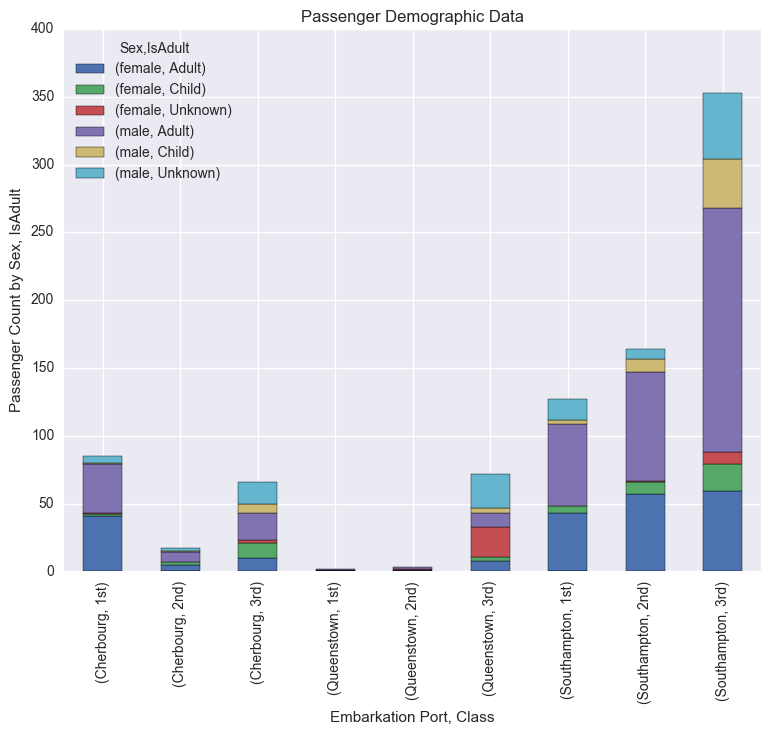

In [33]:
ax = demo_titanic.plot.bar(stacked=True, figsize=(9, 7));
ax.set(xlabel="Embarkation Port, Class", ylabel="Passenger Count by Sex, IsAdult", title="Passenger Demographic Data")

Since he figure above proved data  was a bit hard to see for port C and Q,  I decided to break titanic_df by ports. 
It seems there are a lot more passengers boarded from Southampton than the other two, Cherbourg and Queenstown combined.  


#### Splitting Data by Embarkation Ports

In [20]:
c_titanic_df = demo_titanic[:3];
q_titanic_df = demo_titanic[3:6];
s_titanic_df = demo_titanic[6:];

#### Demographic Data Boarded at  Cherbourg (C) Embarkation Ports

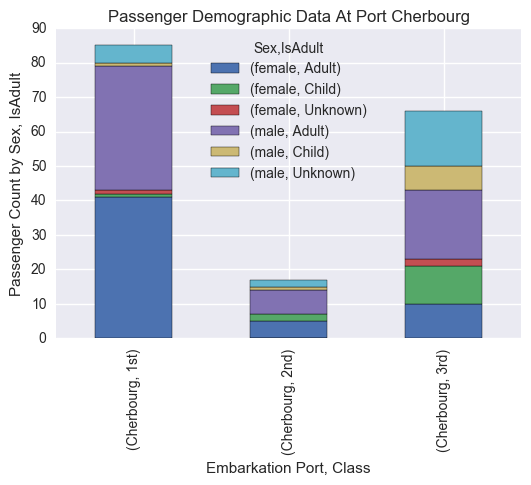

In [35]:
ax = c_titanic_df.plot.bar(stacked=True);
ax.set(xlabel="Embarkation Port, Class", ylabel="Passenger Count by Sex, IsAdult", title="Passenger Demographic Data At Port Cherbourg")

#### Demographic Data Boarded at  Queenstown (Q) Embarkation Ports

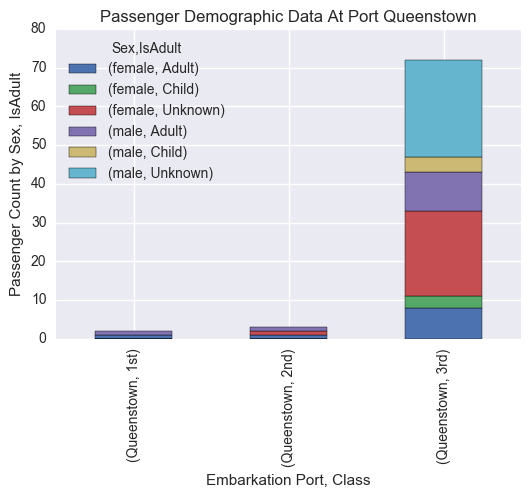

In [37]:
ax = q_titanic_df.plot.bar(stacked=True);
ax.set(xlabel="Embarkation Port, Class", ylabel="Passenger Count by Sex, IsAdult", title="Passenger Demographic Data At Port Queenstown")

#### Demographic Data Boarded at  Southampthon (S) Embarkation Ports

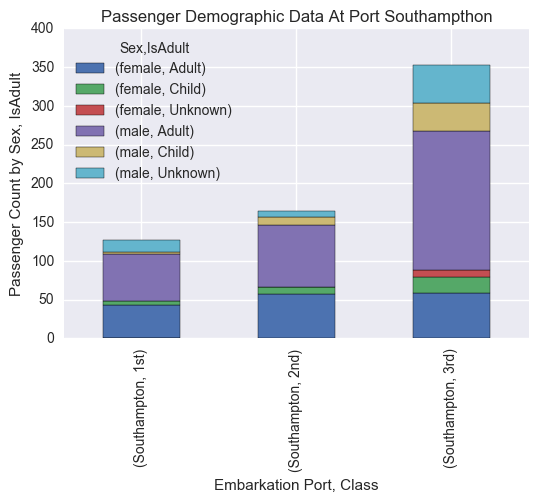

In [38]:
ax = s_titanic_df.plot.bar(stacked=True);
ax.set(xlabel="Embarkation Port, Class", ylabel="Passenger Count by Sex, IsAdult", title="Passenger Demographic Data At Port Southampthon")

##### Since the ports of embarkation information isn't really related to my questions, I moved on to focus more on Class, Sex and Age/IsAdult data.   

## Demographic Data by 'Pclass', 'Sex', 'IsAdult'

In [24]:
class_sex_adult_titanic = pd.pivot_table(titanic_df, values='PassengerId', index=['Class'], columns=['Sex','IsAdult'], aggfunc=np.count_nonzero, fill_value=0)
print(class_sex_adult_titanic.columns)
print(class_sex_adult_titanic.index)
class_sex_adult_titanic


MultiIndex(levels=[['female', 'male'], ['Adult', 'Child', 'Unknown']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]],
           names=['Sex', 'IsAdult'])
Index(['1st', '2nd', '3rd'], dtype='object', name='Class')


Sex     female                male              
IsAdult  Adult Child Unknown Adult Child Unknown
Class                                           
1st         87     6       1    98     4      20
2nd         63    11       2    88    11       9
3rd         77    34      33   210    47      90

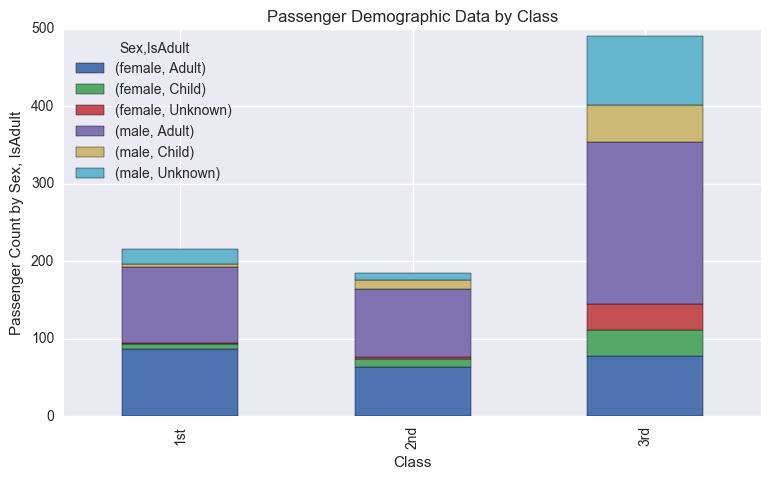

In [40]:
ax = class_sex_adult_titanic.plot.bar(stacked=True, figsize=(9, 5));
ax.set(xlabel="Class", ylabel="Passenger Count by Sex, IsAdult", title="Passenger Demographic Data by Class")

## Survivial Data by 'Pclass', 'Sex', 'IsAdule'

In [26]:
survival_class_sex_adult_titanic = pd.pivot_table(titanic_df, values='Survived', index=['Class'], columns=['Sex','IsAdult'], aggfunc=np.sum)
print(survival_class_sex_adult_titanic.columns)
print(survival_class_sex_adult_titanic.index)
survival_class_sex_adult_titanic

MultiIndex(levels=[['female', 'male'], ['Adult', 'Child', 'Unknown']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]],
           names=['Sex', 'IsAdult'])
Index(['1st', '2nd', '3rd'], dtype='object', name='Class')


Sex     female                male              
IsAdult  Adult Child Unknown Adult Child Unknown
Class                                           
1st         85     5       1    36     4       5
2nd         57    11       2     6     9       2
3rd         35    18      19    28    12       7

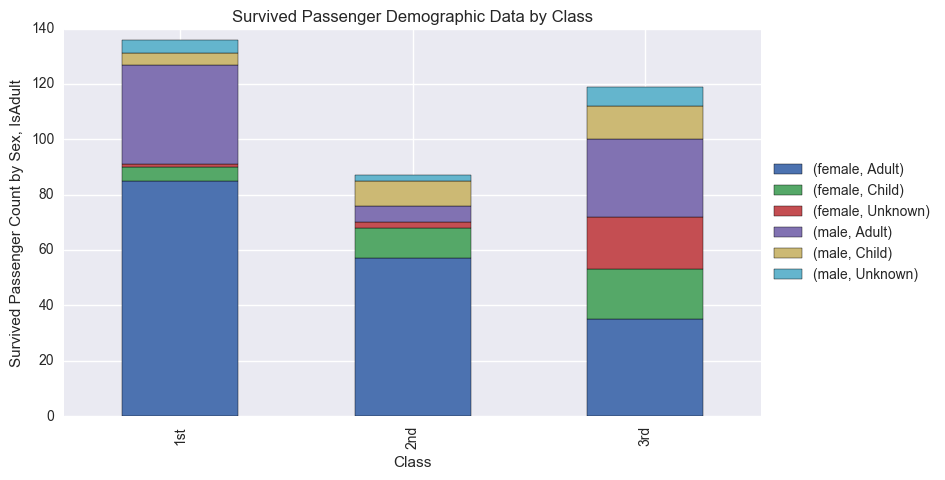

In [45]:
ax = survival_class_sex_adult_titanic.plot.bar(stacked=True, figsize=(9, 5));
ax.set(xlabel="Class", ylabel="Survived Passenger Count by Sex, IsAdult", title="Survived Passenger Demographic Data by Class")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [28]:
survival_class_sex_adult_rate = survival_class_sex_adult_titanic.divide(class_sex_adult_titanic.values, axis=0)

print(survival_class_sex_adult_rate['female'])
print(survival_class_sex_adult_rate['male'])
print(survival_class_sex_adult_rate.index)
print(survival_class_sex_adult_rate.columns)
survival_class_sex_adult_rate

IsAdult     Adult     Child   Unknown
Class                                
1st      0.977011  0.833333  1.000000
2nd      0.904762  1.000000  1.000000
3rd      0.454545  0.529412  0.575758
IsAdult     Adult     Child   Unknown
Class                                
1st      0.367347  1.000000  0.250000
2nd      0.068182  0.818182  0.222222
3rd      0.133333  0.255319  0.077778
Index(['1st', '2nd', '3rd'], dtype='object', name='Class')
MultiIndex(levels=[['female', 'male'], ['Adult', 'Child', 'Unknown']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]],
           names=['Sex', 'IsAdult'])


Sex        female                          male                    
IsAdult     Adult     Child   Unknown     Adult     Child   Unknown
Class                                                              
1st      0.977011  0.833333  1.000000  0.367347  1.000000  0.250000
2nd      0.904762  1.000000  1.000000  0.068182  0.818182  0.222222
3rd      0.454545  0.529412  0.575758  0.133333  0.255319  0.077778

In [29]:
survival_class_sex_adult_rate['female'].describe()

IsAdult,Adult,Child,Unknown
count,3.000000,3.000000,3.000000
mean,0.778773,0.787582,0.858586
std,0.283104,0.238607,0.244936
min,0.454545,0.529412,0.575758
25%,0.679654,0.681373,0.787879
50%,0.904762,0.833333,1.000000
75%,0.940887,0.916667,1.000000
max,0.977011,1.000000,1.000000


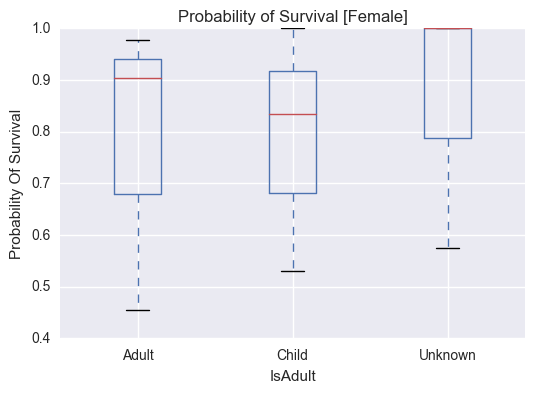

In [46]:
ax = survival_class_sex_adult_rate['female'].plot.box()
ax.set(xlabel="IsAdult", ylabel="Probability Of Survival", title="Probability of Survival [Female]")


In [47]:
survival_class_sex_adult_rate['male'].describe()


IsAdult,Adult,Child,Unknown
count,3.000000,3.000000,3.000000
mean,0.189621,0.691167,0.183333
std,0.157325,0.388249,0.092463
min,0.068182,0.255319,0.077778
25%,0.100758,0.536750,0.150000
50%,0.133333,0.818182,0.222222
75%,0.250340,0.909091,0.236111
max,0.367347,1.000000,0.250000


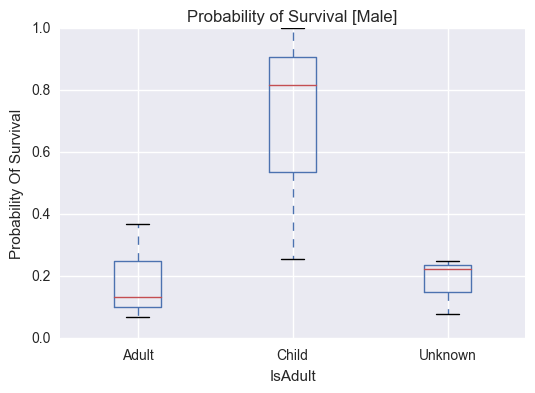

In [48]:
ax = survival_class_sex_adult_rate['male'].plot.box()
ax.set(xlabel="IsAdult", ylabel="Probability Of Survival", title="Probability of Survival [Male]")


In [50]:
transposed_survival_rate = survival_class_sex_adult_rate.T
transposed_survival_rate

Class                1st       2nd       3rd
Sex    IsAdult                              
female Adult    0.977011  0.904762  0.454545
       Child    0.833333  1.000000  0.529412
       Unknown  1.000000  1.000000  0.575758
male   Adult    0.367347  0.068182  0.133333
       Child    1.000000  0.818182  0.255319
       Unknown  0.250000  0.222222  0.077778

In [51]:
transposed_survival_rate.describe()

Class,1st,2nd,3rd
count,6.000000,6.000000,6.000000
mean,0.737949,0.668891,0.337691
std,0.340303,0.414139,0.211277
min,0.250000,0.068182,0.077778
25%,0.483844,0.371212,0.163830
50%,0.905172,0.861472,0.354932
75%,0.994253,0.976190,0.510695
max,1.000000,1.000000,0.575758


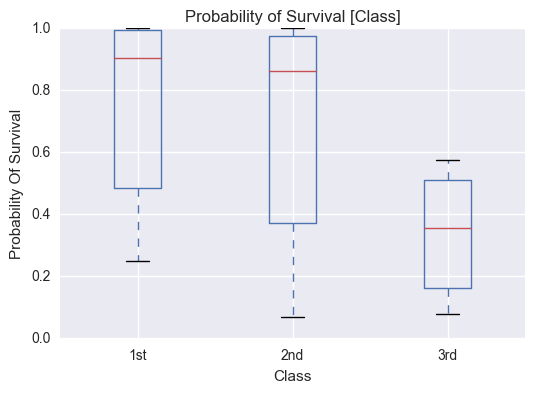

In [52]:
ax = transposed_survival_rate.plot.box()
ax.set(xlabel="Class", ylabel="Probability Of Survival", title="Probability of Survival [Class]")


## Inferential Statistics - Chi-Squared Test

From the quick exploration above, it appears:
1.  Women had higher survival rate than men
2.  Children had higher survival rate than adults
3.  1st class passengers had higher survival rate than 2nd and 3rd class.  


At this point, it makes sense to further break down my previous survival question:    
1. Did women have higher chance of survival than men on Titanic?    
2. Did children have higher chance of survival than adult?   
3. Did people from 1st class have higher chance of survival than 2nd, 3rd classes?     

Chi Squared Test would be appropriate here to perform further analysis on categorical data we have here.  

### Case 1:  Women vs Men

#### Hypothesis Statements:

Null Hypothesis: Normalized survivor count for Men and Women are the same.  
Alternative Hypothesis:  Normalized survivor count for Men and Women are different. 

\begin{equation*}
H_{0}: Norm\_Survived_{f} = Norm\_Survived_{m} \\\\
H_{a}: Norm\_Survived_{f} \neq  Norm\_Survived_{m} \\\\
\text{where } H_{0} \text{ is the null hypothesis - expected frequencies; } \\\\
\text{and } H_{a} \text{ is the alternative hypothesis - observed frequencies; } \\\\
\text{and } Norm\_Survived_{f} \text{ is the normalized survivor count of female passengers; } \\\\
\text{and } Norm\_Survived_{m} \text{ is the normalized survivor count of male passengers; } \\\\
\end{equation*}

In [37]:
class_sex_adult_titanic

Sex     female                male              
IsAdult  Adult Child Unknown Adult Child Unknown
Class                                           
1st         87     6       1    98     4      20
2nd         63    11       2    88    11       9
3rd         77    34      33   210    47      90

#### Overall Survivor Count and Survivor Rate


In [38]:
total_passenger = titanic_df['PassengerId'].count()
total_passenger

891

In [39]:
survivied_df = titanic_df[(titanic_df.Survived == 1)]
total_survived = survivied_df['PassengerId'].count()
total_survived

342

In [40]:
overall_survival_rate = total_survived/total_passenger
overall_survival_rate

0.38383838383838381

#### Expected Female Survivor Count 

In [41]:
female_df = titanic_df[(titanic_df.Sex == 'female')]
total_female = female_df['PassengerId'].count()
total_female

314

In [42]:
expected_survived_female = overall_survival_rate * total_female
expected_survived_female = int(floor(expected_survived_female))
expected_survived_female

120

#### Observed Female Survivor Count and Survival Rate

In [43]:
survived_female_df = titanic_df[(titanic_df.Sex == 'female') & titanic_df.Survived == 1]
observed_survived_female = survived_female_df['PassengerId'].count()
observed_survived_female

233

In [44]:
observed_survival_rate_female = observed_survived_female/total_female
observed_survival_rate_female

0.7420382165605095

#### Expected Male Survivor Count 

In [45]:
male_df = titanic_df[(titanic_df.Sex == 'male')]
total_male = male_df['PassengerId'].count()
total_male

577

In [46]:
expected_survived_male = overall_survival_rate * total_male
expected_survived_male = int(floor(expected_survived_male))
expected_survived_male

221

#### Observed Male Survivor Count and Survival Rate

In [47]:
survived_male_df = titanic_df[(titanic_df.Sex == 'male') & titanic_df.Survived == 1]
observed_survived_male = survived_male_df['PassengerId'].count()
observed_survived_male

109

In [48]:
observed_survival_rate_male = observed_survived_male/total_male
observed_survival_rate_male

0.18890814558058924

#### Expected and Observed Outcome Table for $\chi^2$ Test

|      |  Female  |  Male  |
|------|----------|--------|
|  H_0 |   120    |   221  |   
|  H_a |   233    |   109  |


In [49]:
chi_sq = (((observed_survived_female - expected_survived_female)**2) /expected_survived_female) + (((observed_survived_male - expected_survived_male)**2) /expected_survived_male) 
chi_sq


163.16851432880844

#### Calculate P Value

I use the http://www.graphpad.com/quickcalcs/pValue1/ to calculate the P value.  

With degree of freedom = 1, and $\chi^2$ = 163.1685, the two-tailed P value is less than 0.0001.  By conventional criteria, this difference is considered to be extremely statistically significant. 

Therefore being female could have much higher rate of survival.  


### Case 2:  Children vs Adults

#### Hypothesis Statements:

Null Hypothesis: Normalized Survivor Counts for Children and Adults are the same.  
Alternative Hypothesis:  Normalized Survivor Counts for Children and Adults are different. 

\begin{equation*}
H_{0}: Norm\_Survived_{c} = Norm\_Survived_{a} \\\\
H_{a}: Norm\_Survived_{c} \neq  Norm\_Survived_{a} \\\\
\text{where } H_{0} \text{ is the null hypothesis - expected frequencies; } \\\\
\text{and } H_{a} \text{ is the alternative hypothesis - observed frequencies; } \\\\
\text{and } Norm\_Survived_{c} \text{ is the normalized survivor count of child passengers; } \\\\
\text{and } Norm\_Survived_{a} \text{ is the normalized survivor count of adult passengers; } \\\\
\end{equation*}

Because some of the age data are missing, to perform analysis on this factor, we need to remove the passenger data whom we cannot categorize them into adult/child.  

In [50]:
dropna_titanic_df = titanic_df[titanic_df.IsAdult != 'Unknown']
dropna_titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketClean,ArrayCabin,Port,Class,IsAdult
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.,21171,[nan],Southampton,3rd,Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,17599,[C85],Cherbourg,1st,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.,3101282,[nan],Southampton,3rd,Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,113803,[C123],Southampton,1st,Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.,373450,[nan],Southampton,3rd,Adult
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr.,17463,[E46],Southampton,1st,Adult
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master.,349909,[nan],Southampton,3rd,Child
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Mrs.,347742,[nan],Southampton,3rd,Adult
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Mrs.,237736,[nan],Cherbourg,2nd,Adult
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,Miss.,9549,[G6],Southampton,3rd,Child


In [51]:
dropna_class_titanic = pd.pivot_table(dropna_titanic_df, values='PassengerId', index=['Class'], columns=['IsAdult'], aggfunc=np.count_nonzero, fill_value=0)
dropna_class_titanic

IsAdult,Adult,Child
Class,,
1st,185,10
2nd,151,22
3rd,287,81


#### Overall dropna_titanic Survivor Count and Survivor Rate



In [52]:
total_dropna_passenger = dropna_titanic_df['PassengerId'].count()
total_dropna_passenger

736

In [53]:
survived_dropna_df = dropna_titanic_df[(dropna_titanic_df.Survived == 1)]
total_dropna_survived = survived_dropna_df['PassengerId'].count()
total_dropna_survived

306

In [54]:
overall_dropna_survival_rate = total_dropna_survived/total_dropna_passenger
overall_dropna_survival_rate

0.41576086956521741

#### Expected Child Survivor Count 

In [55]:
child_dropna_df = dropna_titanic_df[(dropna_titanic_df.IsAdult == 'Child')]
total_child = child_dropna_df['PassengerId'].count()
total_child

113

In [56]:
expected_survived_child = overall_dropna_survival_rate * total_child
expected_survived_child = int(floor(expected_survived_child))
expected_survived_child

46

#### Observed Child Survivor Count and Survival Rate

In [57]:
survived_child_df = dropna_titanic_df[(dropna_titanic_df.IsAdult == 'Child') & dropna_titanic_df.Survived == 1]
observed_survived_child = survived_child_df['PassengerId'].count()
observed_survived_child

59

In [58]:
observed_survival_rate_child = observed_survived_child/total_child
observed_survival_rate_child

0.52212389380530977

#### Expected Adult Survivor Count 

In [59]:
adult_dropna_df = dropna_titanic_df[(dropna_titanic_df.IsAdult == 'Adult')]
total_adult = adult_dropna_df['PassengerId'].count()
total_adult

623

In [60]:
expected_survived_adult = overall_dropna_survival_rate * total_adult
expected_survived_adult = int(floor(expected_survived_adult))
expected_survived_adult

259

#### Observed Adult Survivor Count and Survival Rate

In [61]:
survived_adult_df = dropna_titanic_df[(dropna_titanic_df.IsAdult == 'Adult') & dropna_titanic_df.Survived == 1]
observed_survived_adult = survived_adult_df['PassengerId'].count()
observed_survived_adult

247

In [62]:
observed_survival_rate_adult = observed_survived_adult/total_adult
observed_survival_rate_adult

0.39646869983948635

#### Expected and Observed Outcome Table for $\chi^2$ Test

|      |  Child  |  Adult |
|------|---------|--------|
|  H_0 |    46   |   259  |   
|  H_a |    59   |   247  |


In [63]:
chi_sq = (((observed_survived_child - expected_survived_child)**2) /expected_survived_child) + (((observed_survived_adult - expected_survived_adult)**2) /expected_survived_adult) 
chi_sq


4.2298975994628165

#### Calculate P Value

I use the http://www.graphpad.com/quickcalcs/pValue1/ to calculate the P value.  

With degree of freedom = 1, and $\chi^2$ = 4.23, the two-tailed P value is less than 0.0397.  By conventional criteria, this difference is considered to be statistically significant at 95% confidence interval.  

Therefore being child could have a higher chance of survival.  


### Case 3:  Survival Rate by Class

#### Hypothesis Statements:

Null Hypothesis: Normalized Survivor Counts for 1st, 2nd and 3rd class are the same.  
Alternative Hypothesis:  Normalized Survivor Counts for 1st, 2nd and 3rd class are different. 

\begin{equation*}
H_{0}: Norm\_Survived_{1st} = Norm\_Survived_{2nd} = Norm\_Survived_{3rd} \\\\
H_{a}: Norm\_Survived_{1st} \neq Norm\_Survived_{2nd} \neq Norm\_Survived_{3rd}  \\\\
\text{where } H_{0} \text{ is the null hypothesis - expected frequencies; } \\\\
\text{and } H_{a} \text{ is the alternative hypothesis - observed frequencies; } \\\\
\text{and } Norm\_Survived_{1st} \text{ is the normalized survivor count of 1st class passengers; } \\\\
\text{and } Norm\_Survived_{2nd} \text{ is the normalized survivor count of 2nd class  passengers; } \\\\
\text{and } Norm\_Survived_{3rd} \text{ is the normalized survivor count of 3rd class  passengers; } \\\\
\end{equation*}

In [64]:
class_titanic_df = class_sex_adult_titanic.T
class_titanic_df

Class           1st  2nd  3rd
Sex    IsAdult               
female Adult     87   63   77
       Child      6   11   34
       Unknown    1    2   33
male   Adult     98   88  210
       Child      4   11   47
       Unknown   20    9   90

#### Overall Survivor Count and Survivor Rate


In [65]:
total_passenger = titanic_df['PassengerId'].count()
total_passenger

891

In [66]:
survived_df = titanic_df[(titanic_df.Survived == 1)]
total_survived = survived_df['PassengerId'].count()
total_survived

342

In [67]:
overall_survival_rate = total_survived/total_passenger
overall_survival_rate

0.38383838383838381

#### Expected 1st Class Survivor Count 

In [68]:
first_class_df = titanic_df[(titanic_df.Pclass == 1)]
total_first_class = first_class_df['PassengerId'].count()
total_first_class

216

In [69]:
expected_survived_first_class = overall_survival_rate * total_first_class
expected_survived_first_class = int(floor(expected_survived_first_class))
expected_survived_first_class

82

#### Observed 1st Class Survivor Count and Survival Rate

In [70]:
survived_first_class_df = titanic_df[(titanic_df.Pclass == 1) & titanic_df.Survived == 1]
observed_survived_first_class = survived_first_class_df['PassengerId'].count()
observed_survived_first_class

136

In [71]:
observed_survival_rate_first_class = observed_survived_first_class/total_first_class
observed_survival_rate_first_class

0.62962962962962965

#### Expected 2nd Class Survivor Count 

In [72]:
second_class_df = titanic_df[(titanic_df.Pclass == 2)]
total_second_class = second_class_df['PassengerId'].count()
total_second_class

184

In [73]:
expected_survived_second_class = overall_survival_rate * total_second_class
expected_survived_second_class = int(floor(expected_survived_second_class))
expected_survived_second_class

70

#### Observed 2nd Class Survivor Count and Survival Rate

In [74]:
survived_second_class_df = titanic_df[(titanic_df.Pclass == 2) & titanic_df.Survived == 1]
observed_survived_second_class = survived_second_class_df['PassengerId'].count()
observed_survived_second_class

87

In [75]:
observed_survival_rate_second_class = observed_survived_second_class/total_second_class
observed_survival_rate_second_class

0.47282608695652173

#### Expected 3rd Class Survivor Count 

In [76]:
third_class_df = titanic_df[(titanic_df.Pclass == 3)]
total_third_class = third_class_df['PassengerId'].count()
total_third_class

491

In [77]:
expected_survived_third_class = overall_survival_rate * total_third_class
expected_survived_third_class = int(floor(expected_survived_third_class))
expected_survived_third_class

188

#### Observed 3rd Class Survivor Count and Survival Rate

In [78]:
survived_third_class_df = titanic_df[(titanic_df.Pclass == 3) & titanic_df.Survived == 1]
observed_survived_third_class = survived_third_class_df['PassengerId'].count()
observed_survived_third_class

119

In [79]:
observed_survival_rate_third_class = observed_survived_third_class/total_third_class
observed_survival_rate_third_class

0.24236252545824846

#### Expected and Observed Outcome Table for $\chi^2$ Test

|      |  1st  |  2nd  |  3rd  |
|------|-------|-------|-------|
|  H_0 |   82  |   70  |  188  |
|  H_a |  136  |   87  |  119  |


In [80]:
chi_sq = (((observed_survived_first_class - expected_survived_first_class)**2) /expected_survived_first_class) + (((observed_survived_second_class - expected_survived_second_class)**2) /expected_survived_second_class) + (((observed_survived_third_class - expected_survived_third_class)**2) /expected_survived_third_class) 
chi_sq


65.014015123433907

#### Calculate P Value

I use the http://www.graphpad.com/quickcalcs/pValue1/ to calculate the P value.  

With degree of freedom = 2, and $\chi^2$ = 65.014, the two-tailed P value is less than 0.0001.  By conventional criteria, this difference is considered to be _*extremely statistically significant*_.  

Therefore being at a higher social significantly correlates to higher chance of survival.  


## Titanic Survival Data Visualization

In [81]:
dropna_titanic_df = titanic_df[titanic_df.IsAdult != 'Unknown']
dropna_titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketClean,ArrayCabin,Port,Class,IsAdult
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.,21171,[nan],Southampton,3rd,Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,17599,[C85],Cherbourg,1st,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.,3101282,[nan],Southampton,3rd,Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,113803,[C123],Southampton,1st,Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.,373450,[nan],Southampton,3rd,Adult
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr.,17463,[E46],Southampton,1st,Adult
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master.,349909,[nan],Southampton,3rd,Child
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Mrs.,347742,[nan],Southampton,3rd,Adult
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Mrs.,237736,[nan],Cherbourg,2nd,Adult
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,Miss.,9549,[G6],Southampton,3rd,Child


In [82]:
dropna_demo_titanic = pd.pivot_table(dropna_titanic_df, values='PassengerId', columns=['Class', 'Sex','IsAdult'], aggfunc=np.count_nonzero)

# Fill na in demo_titanic with 0

dropna_demo_titanic

Class  Sex     IsAdult
1st    female  Adult       87
               Child        6
       male    Adult       98
               Child        4
2nd    female  Adult       63
               Child       11
       male    Adult       88
               Child       11
3rd    female  Adult       77
               Child       34
       male    Adult      210
               Child       47
dtype: int64

In [83]:
dropna_survival_titanic = pd.pivot_table(dropna_titanic_df, values='Survived', columns=['Class', 'Sex','IsAdult'], aggfunc=np.sum)

dropna_survival_titanic

Class  Sex     IsAdult
1st    female  Adult      85
               Child       5
       male    Adult      36
               Child       4
2nd    female  Adult      57
               Child      11
       male    Adult       6
               Child       9
3rd    female  Adult      35
               Child      18
       male    Adult      28
               Child      12
dtype: int64

In [84]:
dropna_survival_rate_series = dropna_survival_titanic.divide(dropna_demo_titanic.values, axis=0)
dropna_survival_rate_series

Class  Sex     IsAdult
1st    female  Adult      0.977011
               Child      0.833333
       male    Adult      0.367347
               Child      1.000000
2nd    female  Adult      0.904762
               Child      1.000000
       male    Adult      0.068182
               Child      0.818182
3rd    female  Adult      0.454545
               Child      0.529412
       male    Adult      0.133333
               Child      0.255319
dtype: float64

In [86]:
plt_df = dropna_survival_rate_series.reset_index()
plt_df.columns = ['Class', 'Sex', 'IsAdult', 'SurvivalRate']
plt_df

,Class,Sex,IsAdult,SurvivalRate
0,1st,female,Adult,0.977011
1,1st,female,Child,0.833333
2,1st,male,Adult,0.367347
3,1st,male,Child,1.000000
4,2nd,female,Adult,0.904762
5,2nd,female,Child,1.000000
6,2nd,male,Adult,0.068182
7,2nd,male,Child,0.818182
8,3rd,female,Adult,0.454545
9,3rd,female,Child,0.529412


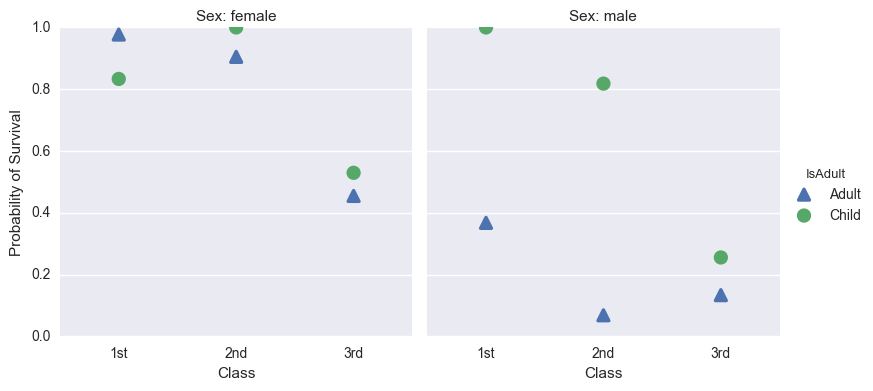

In [95]:
g = sns.factorplot(x="Class", y="SurvivalRate", hue="IsAdult", join=False, despine=True,
               col="Sex", markers=["^", "o"], data=plt_df, kind="point");
g.set_axis_labels("Class", "Probability of Survival").set_titles("{col_var}: {col_name}").set(ylim=(0, 1)).despine(left=True)

## References and Resources Used:
1.  http://seaborn.pydata.org/tutorial/categorical.html
2.  http://seaborn.pydata.org/generated/seaborn.factorplot.html#seaborn.factorplot
3.  http://matplotlib.org/api/pyplot_summary.html
4.  http://pandas.pydata.org/pandas-docs/stable/
5.  http://www.graphpad.com/quickcalcs/pValue1/
6.  https://discussions.udacity.com/t/how-to-understand-which-statistical-should-i-use-on-a-dataset/182390/2
7.  https://inclass.kaggle.com/c/titanic-survival/data


## Data Wrangling with Python

In [96]:
"""
This code is mainly to achieve the following: 
    * Extract `LastName`, `Title`, `FirstName`, `OtherName` (in parenthesis) from `Name` field into mentioned separate columns.   
    * Clean up `Ticket` column so the `Ticket` data only consists of digits.  
    * Clean up `Cabin` column so the data is in list form eg. `['C10', 'A23']`.    
    * Add `Adult` column to categorize passenger as Adult (Age >= 18) or Child (Age < 18).   
    * When `Age` data is not available, see if we could use honorific title to determine if passenger is an adult.  
    
"""
import codecs
import csv
import pprint
import os


TITANIC = 'titanic-data.csv'
MY_TITANIC = 'mytitanic-data.csv'

FIELDS = {'PassengerId': 'passenger_id',
         'Survived': 'survived',
         'Pclass': 'p_class',
         'Name': 'name',
         'Sex': 'sex',
         'Age': 'age',
         'SibSp': 'sib_sp',
         'Parch': 'par_ch',
         'Ticket': 'ticket',
         'Fare': 'fare',
         'Cabin': 'cabin',
         'Embarked': 'port'}

PORTS = {'C': 'Cherbourg',
         'Q': 'Queenstown',
         'S': 'Southampton'}

P_CLASS = {'1': '1st',
           '2': '2nd',
           '3': '3rd'}

def fix_datatype(s):
    try:
        s = float(s)
        if s.is_integer():
            return int(s)
        else:
            return s
    except (TypeError, ValueError):
        return s


def parse_array(v):
    if (v[0] == "{") and (v[-1] == "}"):
        v = v.lstrip("{")
        v = v.rstrip("}")
        v_array = v.split("|")
        v_array = [ i.strip() for i in v_array]
        return v_array
    return [v]

def parse_name(v):
    # (Sylvia Mae Harbaugh) :: Caldwell, Mrs. Albert Francis 
    
    if (v.find("(") > -1) and (v.find(")") > -1):
        other = v[v.index("("):].strip()
        first = v[v.index(".") + 1:v.index("(")].strip()
    else: 
        other = ""
        first = v[v.index(".") + 1:].strip()
    title = v[v.index(",") + 1:v.index(".") + 1].strip()
    last = v[:v.index(",")].strip()
        
        
    return [last, title, first, other]

def process_file(filename, fields):
    data = []
    with open(filename, "r") as f:
        reader = csv.DictReader(f)
        
        # processing file
        for line in reader:

            data_point = {}

            for key, value in fields.items():
                
                if (key == 'Name'):
                    names = parse_name(str(line[key]))
                    data_point['last'] = names[0]
                    data_point['title'] = names[1]
                    data_point['first'] = names[2]
                    data_point['other'] = names[-1]
                elif (key == 'SibSp') or (key == 'Parch'):
                    line[key] = int(line[key])
                elif (key == 'Age') or (key == 'Fare'):
                    if line[key] != "":
                        line[key] = float(line[key])
                    
                elif (key == 'Ticket'):
                    v_array = str(line[key]).split()
                    v_array = [ i.strip() for i in v_array]
                    line[key] = v_array[-1]
                elif (key == 'Cabin'):
                    v_array = str(line[key]).split()
                    v_array = [ i.strip() for i in v_array]
                    line[key] = v_array
                    
                data_point[value] = line[key]
#             data_point = add_is_adult(data_point)
            data.append(data_point)
    return data


def add_is_adult(data_point):
    age = data_point['age']
    title = data_point['title']
    data_point['adult'] = None
    if age != '':
        if age >= 18:
            data_point['adult'] = bool(1)
        else: 
            data_point['adult'] =  bool(0)
    else: 
        if title == 'Mrs.' or title == 'Dr.':
            data_point['adult'] =  bool(1)
        elif title == 'Master.':
            data_point['adult'] =  bool(0)
    return(data_point)

def write_csv_file(filename, csv_columns, data):
    try:
        with open(filename, 'w') as f:
            writer = csv.DictWriter(f, fieldnames=csv_columns)
            writer.writeheader()
            for l in data:
                writer.writerow(l)
    except IOError:
        print("I/O error()")
    return

def insert_mongodb(data):
    from pymongo import MongoClient
    client = MongoClient("mongodb://localhost:27017")
    db = client.examples

    collection = db.mycities
    for item in data:
        print(item)
        collection.insert(item)

def test():
    data = process_file(TITANIC, FIELDS)

    # insert_mongodb(data)
    # Add new name fields and adult_child fields
    FIELDS['LastName'] = 'last'
    FIELDS['Title'] = 'title'
    FIELDS['FirstName'] = 'first'
    FIELDS['OtherName'] = 'other'
#     FIELDS['Adult'] = 'adult'
    
    csv_columns = FIELDS.values()
    write_csv_file(MY_TITANIC, csv_columns, data)


if __name__ == "__main__":
    test()
